# HarvestStat Data Profiling - DRC

In [1]:
import glob, json
import warnings
from functools import reduce
warnings.simplefilter(action='ignore', category=FutureWarning)
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
from tools import save_npz, PrintAdminUnits, PlotAdminShapes
from tools import FDW_PD_Sweeper, FDW_PD_AvalTable, FDW_PD_Compiling, FDW_PD_ValidateFnidName
from tools import FDW_PD_CreateAdminLink, FDW_PD_RatioAdminLink, FDW_PD_ConnectAdminLink
from tools import FDW_PD_CaliSeasonYear
from tools_graphic import PlotBarProduction, PlotLinePAY
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
pd.options.mode.chained_assignment = None

In [2]:
# Load FEWS NET administrative boundaries ------- #
epsg = 'epsg:32732' # DRC
fn_shapes = sorted(glob.glob('../data/shapefile/fewsnet/CD_Admin?_????.shp'))
shape_all = []
for fn in fn_shapes:
    name = fn[-18:-4]
    exec('%s = gpd.read_file("%s").to_crs("%s")' % (name, fn, epsg))
    exec('%s["area"] = %s["geometry"].area/10**6' % (name, name))
    exec('shape_all.append(%s)' % (name))
shape_all = pd.concat(shape_all, axis=0).reset_index(drop=True)
PrintAdminUnits(shape_all)
# ----------------------------------------------- #

# FDW API host address -------------------------- #
host = 'https://fdw.fews.net'
auth = tuple(json.loads(open('token.json', "r").read()))
parameters = {
    'format': 'json',
    'country': 'Congo, The Democratic Republic of the',
    'product': ['R011','R012','R013','R014','R015','R016','R017','R018','R019'],
    'survey_type': 'crop:best'
}
endpoint = '/api/cropproductionindicatorvalue/'
response = requests.get(host + endpoint, auth=auth, params=parameters, proxies={})
response.raise_for_status()
df = pd.DataFrame.from_records(response.json())
# ----------------------------------------------- #

- FEWS NET admin shapefiles ------------------- #
| year	 | Admin1   | # units   | Admin2   | # units   | Admin3   | # units   |
| 1997	 | CD1997A1 | 11	| CD1997A2	| 47	| CD1997A3	| 164	|
| 2007	 | CD2007A1 | 11	| CD2007A2	| 47	| CD2007A3	| 164	|
| 2015	 | CD2015A1 | 26	| CD2015A2	| 241	| nan	| 0	|
| 2017	 | CD2017A1 | 26	| CD2017A2	| 240	| nan	| 0	|
----------------------------------------------- #


In [3]:
# Manual Pre-processing before Sweeping --------- #
# 1. Default setting 
# a) None-type crop production system
df.loc[df['crop_production_system'].isna(), 'crop_production_system'] = 'none'
df.loc[df['crop_production_system'] == '', 'crop_production_system'] = 'none'
# b) None-type population group
df.loc[df['population_group'].isna(), 'population_group'] = 'none'
df.loc[df['population_group'] == '', 'population_group'] = 'none'
# Replace season name
df['season_name'] = df['season_name'].replace({
    'Harvest': "Main"
})
# ----------------------------------------------- #

# FDW Production Data Inspection ---------------- #
df, df_raw = FDW_PD_Sweeper(df, area_priority='Area Planted')
table_dict = FDW_PD_AvalTable(df, shape_all)
# ----------------------------------------------- #

# FEWS NET Shapefile comparison ----------------- #
shape_used = pd.concat([CD_Admin1_2015, CD_Admin3_1997, CD_Admin2_1997], axis=0)
PlotAdminShapes(shape_used, label=True)
# ----------------------------------------------- #

- Remove missing records ---------------------- #
Orignial data points: 7,419
Removed 4,661 "Missing Value" points
324/2,473 "Area Planted" points are retained.
2,110/2,473 "Quantity Produced" points are retained.
324/2,473 "Yield" points are retained.
Current data points: 2,758

- Minor changes are applied ------------------- #

- Basic information --------------------------- #
Data period: 2005 - 2016
5 grain types are found: Beans (mixed), Cassava, Cooking Banana (unspecified), Maize (Corn), Rice (Paddy)
1 seasons are found: Main (01-01)
1 crop production system are found: none
Data sources include:
[1] CCSAP/SIG, Congo, The Democratic Republic of the --- Crop and food security assessment mission, DRC
[2] SNSA, Congo, The Democratic Republic of the --- Annuaire des Statistiques Agricoles (2006-2011), DRC
Administrative-1 fnids: 21
Administrative-2 fnids: 39
0 reporting units are found: 

- Total production over time ------------------ #
season_name                    Main
          

- DRC crop seasonal calendar

![FEWS NET](../figures/crop_calendar/seasonal-calendar-drc.png)

![USDA](https://ipad.fas.usda.gov/rssiws/al/crop_calendar/images/safrica_cg_calendar.png)

<img src="../figures/crop_calendar/seasonal-calendar-drc-fao.jpg"  width="80%" height="30%">

- FDW data consists of `CD1997A2`, `CD1997A3`, and `CD2015A1`.

| Year	 | Admin1   | # units   | Admin2   | # units   | Admin3   | # units   |
| :---: | :----:   | :----:   | :----:   | :---:   |  :----:   | :---:   |
| 1997	 | CD1997A1 | 11	| CD1997A2	| 47	| CD1997A3	| 164	|
| 2007	 | CD2007A1 | 11	| CD2007A2	| 47	| CD2007A3	| 164	|
| 2015	 | **`CD2015A1`** | 26	| CD2015A2	| 241	| nan	| 0	|
| 2017	 | CD2017A1 | 26	| CD2017A2	| 240	| nan	| 0	|

- Comparison between admin boundaries.

![image](../figures/CD_admin_shapes.png )

- DRC has both admin-2 and admin-3 level data from 2005 to 2011. So, it is important to check any duplicated data over the same region.
    - admin-3 level data only exists in `Maniema`, `North Kivu`, and `South Kivu`, and there is no overlap with admin-2 level data (confirmed by Donghoon).
- In 2015, Admin-2 level became Admin-1 level with some aggregation (mostly city boundaries are merged).
- **`CD2015A1`** is used to represent the current admin-level 1 crop data.
- DRC has a single crop season: `Main` (name is changed from `Harvest`).
- DRC has no population group(s).

In [4]:
# Check overlap between admin2 and admin3 ------- #
df['adm_level'] = df['fnid'].apply(lambda x: x[6:8])
a2 = df[df['adm_level'] == 'A2']
a3 = df[df['adm_level'] == 'A3'] # 'Maniema', 'North Kivu', 'South Kivu
assert np.isin(a3['admin_1'].unique(), a2['admin_1'].unique()).sum() == 0

In [5]:
# Define the latest shapefile ------------------- #
latest_level = 1
shape_latest = CD_Admin1_2015.copy().to_crs('epsg:4326')
# ----------------------------------------------- #

# Validation of FNIDs and Names ----------------- #
df = FDW_PD_ValidateFnidName(df, shape_used, shape_latest)
# Manual change
idx = shape_used['FNID'].apply(lambda x: x[6:8] == 'A3')
shape_used.loc[idx, 'name'] = shape_used.loc[idx, 'ADMIN3']
# ----------------------------------------------- #

# FDW Production Data Compiling ----------------- #
area, prod = FDW_PD_Compiling(df, shape_used)
area_all, prod_all = area.copy(), prod.copy()
mdx_pss = area.columns.droplevel([0,1]).unique()
# ----------------------------------------------- #

In [6]:
# Aggregation to lower admin level -------------- #
# Remove duplicated districts in admin-3 shapefile as no crop data there
duplicated = CD_Admin3_1997['FNID'].value_counts()
fnid_duplicated = duplicated.index[duplicated > 1]
assert df['fnid'].isin(fnid_duplicated).sum() == 0
CD_Admin3_1997 = CD_Admin3_1997[~CD_Admin3_1997['FNID'].isin(fnid_duplicated)].reset_index(drop=True)
# We aggregate admin-3 and admin-2 data to admin-1 data
# Generate AdminLink manually
from tools import CreateLinkAdmin, invert_dicts
link_1997a, _, _ = CreateLinkAdmin(CD_Admin1_2015, CD_Admin3_1997, old_on='ADMIN1', new_on='ADMIN3')
link_1997a = invert_dicts(link_1997a)
link_1997b, _, _ = CreateLinkAdmin(CD_Admin1_2015, CD_Admin2_1997, old_on='ADMIN1', new_on='ADMIN2')
link_1997b = invert_dicts(link_1997b)
assert link_1997a.keys() == link_1997b.keys()
link = {}
for fnid in link_1997a.keys():
    link[fnid] = [*link_1997a[fnid], *link_1997b[fnid]]
# Connect data with AdminLink
area_new = []
prod_new = []
for fnid in link.keys():
    area_merged = [area[i].droplevel(0, axis=1) for i in [fnid, *link[fnid]]]
    area_merged = reduce(lambda a, b: a.add(b, fill_value=0), area_merged)
    area_merged.columns = area[fnid].columns
    area_merged = pd.concat([area_merged], keys=[fnid], names=['fnid'], axis=1)
    area_new.append(area_merged)
    prod_merged = [prod[i].droplevel(0, axis=1) for i in [fnid, *link[fnid]]]
    prod_merged = reduce(lambda a, b: a.add(b, fill_value=0), prod_merged)
    prod_merged.columns = prod[fnid].columns
    prod_merged = pd.concat([prod_merged], keys=[fnid], names=['fnid'], axis=1)
    prod_new.append(prod_merged)
area_new = pd.concat(area_new, axis=1)
prod_new = pd.concat(prod_new, axis=1)
assert area.sum().sum().round() == area_new.sum().sum().round()
assert prod.sum().sum().round() == prod_new.sum().sum().round()
# ----------------------------------------------- #

In [7]:
# Manual correction ----------------------------- #
crop_new = prod_new/area_new
# ----------------------------------------------- #

# Complete long format DataFrame ---------------- #
df_area = area_new.T.stack().rename('value').reset_index()
df_area['indicator'] = 'area'
df_prod = prod_new.T.stack().rename('value').reset_index()
df_prod['indicator'] = 'production'
df_yield = (prod_new/area_new).T.stack().rename('value').reset_index()
df_yield['indicator'] = 'yield'
stack = pd.concat([df_area, df_prod, df_yield], axis=0)
# Add "planting year"
cols = ['season_name','product','crop_production_system','planting_month','harvest_year','harvest_month','planting_year']
season_table = df[cols].drop_duplicates()
stack = stack.merge(season_table, on=cols[:-1])
# Add country and admin names
stack = stack.merge(df[['fnid','country','country_code','admin_1','admin_2']].drop_duplicates(), on='fnid', how='inner')
names = [
    'fnid','country','country_code','admin_1','admin_2','name',
    'product','season_name','planting_year','planting_month','harvest_year','harvest_month',
    'crop_production_system','indicator','value'
]
stack = stack[names]
# ----------------------------------------------- #

# Final Processing ------------------------------ #
# Manual change of product name
product_category_custom = {
    'Beans (mixed)': 'Beans (mixed)',
    'Cassava': 'Cassava',
    'Cooking Banana (unspecified)': 'Banana',
    'Maize (Corn)': 'Maize',
    'Rice (Paddy)': 'Rice'
}
assert set(stack['product'].unique()) == set(product_category_custom.keys())
stack['product'] = stack['product'].replace(product_category_custom)
# Calibration of crop calendar using External Crop Calendar (ECC)
# According to the FAO's crop calendar, there are multiple seasons regionally in DRC. However, the FDW data has only "Main" season, we retain 01-01 as planting month and 12-01 as harvest month.
# We assume that the planting year is the same as the harvest year.
ecc = pd.read_csv('../data/crop_calendar/external_crop_calendar.csv')
ecc = ecc[ecc['country'] == 'Congo, The Democratic Republic of the']
stack, link_ratio = FDW_PD_CaliSeasonYear(stack, ecc, link_ratio=None)
# None admin names
stack.loc[stack['admin_1'].isna(), 'admin_1'] = 'none'
stack.loc[stack['admin_2'].isna(), 'admin_2'] = 'none'
# ----------------------------------------------- #

# Save data
fn_out = '../data/crop/adm_crop_production_CD.csv'
stack.to_csv(fn_out); print(f'{fn_out} is saved.')

All [season_name, product, crop_production_system] are in the external crop calendar.
../data/crop/adm_crop_production_CD.csv is saved.


## Visualization of production data

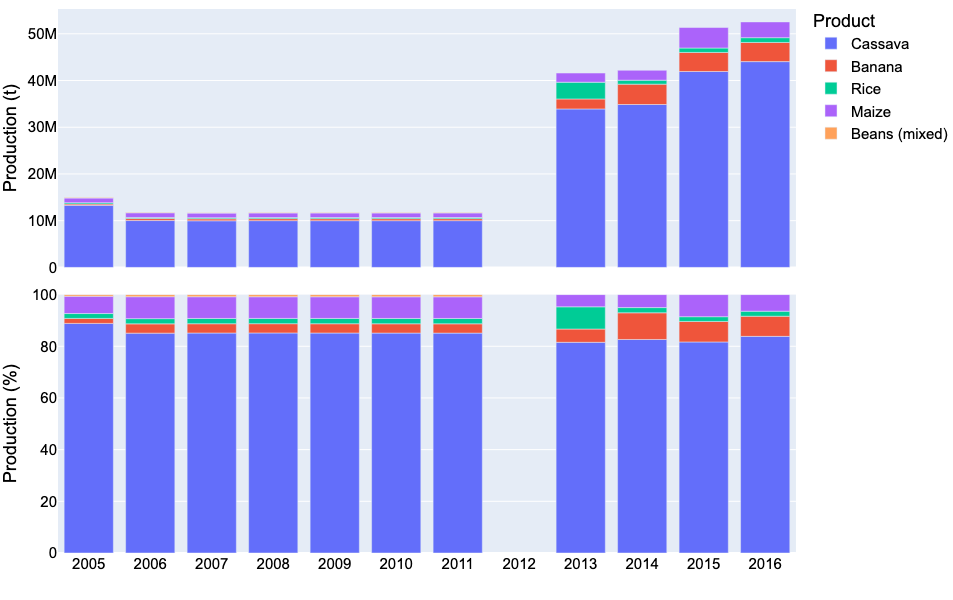

In [8]:
# Bar chart of national crop production
country_iso, country_name = 'CD', 'Congo, The Democratic Republic of the'
df = pd.read_csv('../data/crop/adm_crop_production_%s.csv' % country_iso, index_col=0)
df['year'] = df['harvest_year']
year = [df['year'].min(), df['year'].max()]
product_order = ['Cassava','Banana','Rice','Maize']
for season_name in ['Main']:
    footnote = 'National crop production in %s - %s' % (country_name, season_name)
    fn_save = '../figures/%s_bar_natgrainprod_%s.png' % (country_iso, season_name)
    sub = df[df['season_name'] == season_name]
    fig = PlotBarProduction(sub, year, product_order, footnote)#, fn_save)
    fig.show()

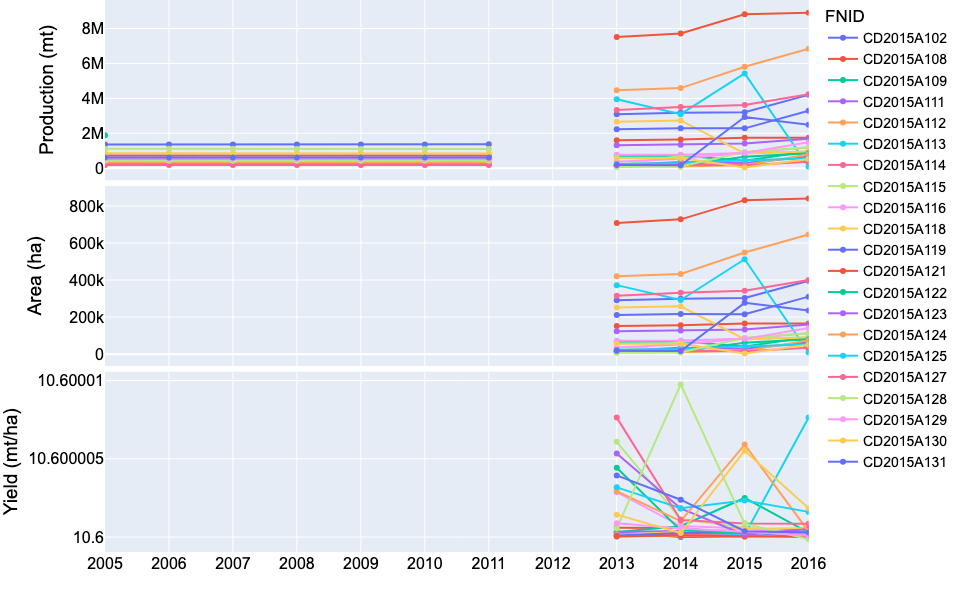

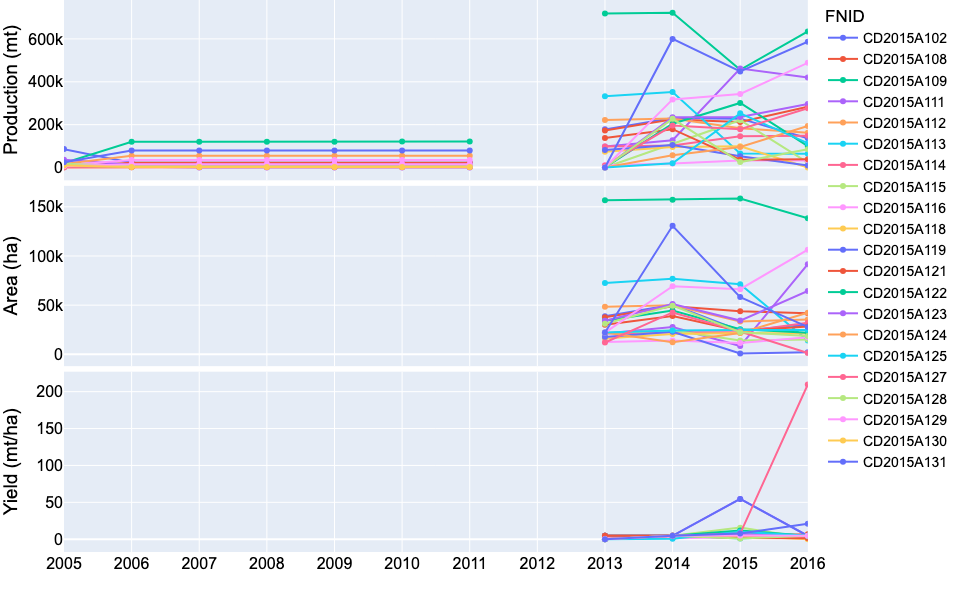

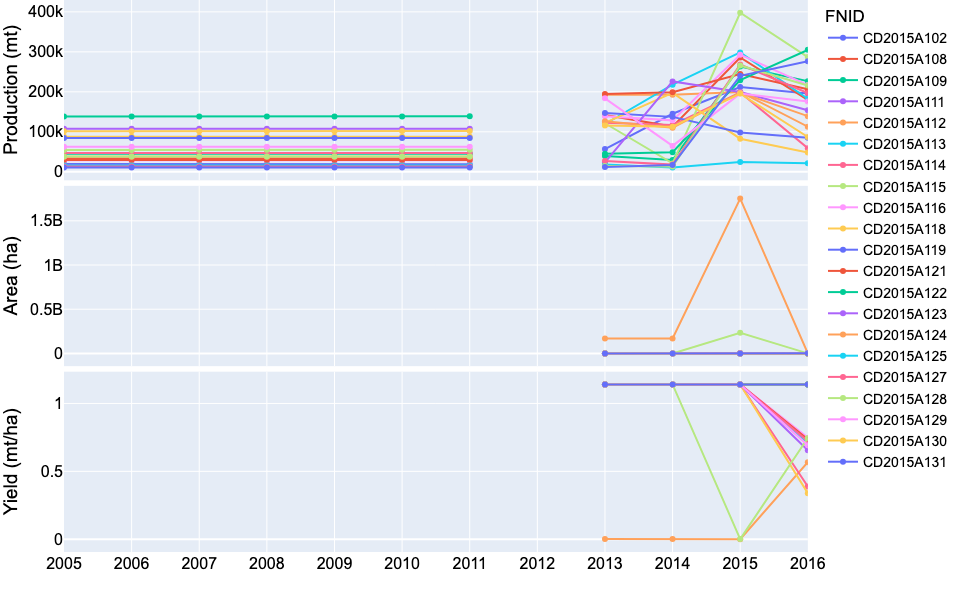

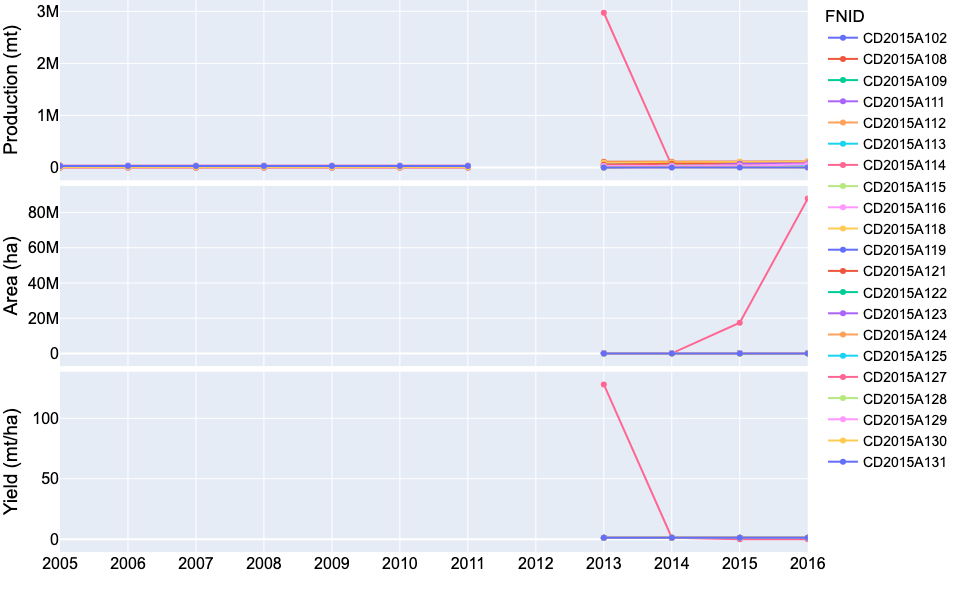

In [9]:
# Lineplot of Production-Area-Yield time-series
country_iso, country_name = 'CD', 'Congo, The Democratic Republic of the'
df = pd.read_csv('../data/crop/adm_crop_production_%s.csv' % country_iso, index_col=0)
df['year'] = df['harvest_year']
year = [df['year'].min(), df['year'].max()]
product_season = [
    ['Cassava','Main'],
    ['Banana','Main'],
    ['Maize','Main'],
    ['Rice','Main'],
]
for product_name, season_name in product_season:
    footnote = 'Production-Area-Yield time-series of %s - %s - %s' % (country_iso, product_name, season_name)
    fn_save = '../figures/%s_line_pay_%s_%s.png' % (country_iso, product_name, season_name)
    sub = df[(df['product'] == product_name) & (df['season_name'] == season_name)]
    fig = PlotLinePAY(sub, year, footnote)#, fn_save)
    fig.show()